# Using MLflow to Track Experiments

## Running an Experiment
In this exercise, you will use the `nyc-taxi` dataset that you created for lab 2 to train a model which predicts the total fare based on a subset of the NYC Taxi & Limousine Commission - green taxi trip records.  You will create a linear regression model as in the prior lab. In this notebook, a key difference is that you will train variants of this model, changing **hyperparameters** to try to achieve better performance.

You will also use MLflow to log the associated metrics, parameters, artifacts, and model for each attempt.  The goal of this process is to determine which hyperparameters work best for generating accurate predictions.  Keeping track of results on your own in a spreadsheet or text document is possible but inefficient.  It would be better to do this work as close to the model and training process as possible.  With MLflow, you can create **experiments** to do just that.  An experiment is a logical collection of **runs**.  Each run is a different attempt at training.  You can control the nature of these runs--in this experiment, you will try out a series of hyperparameters for the same algorithm and data and compare which fares best.  But that's not the only way you can use experiments.  For example, you could create an experiment and have each run of the experiment try out a different algorithm altogether, or create an experiment and have each run look at a different subset of data for training.

### Start Your Cluster
To get started, first attach a Databricks cluster to this notebook.  If you have not created a cluster yet, use the **Clusters** menu on the left-hand sidebar to create a new Databricks cluster.  Then, return to this notebook and attach the newly-created cluster to this notebook.

In [0]:
import urllib.request
import os
import warnings
import sys
import numpy as np
from pyspark.sql.types import * 
from pyspark.sql.functions import col, lit
from pyspark.sql.functions import udf
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import mlflow.spark

print('Loaded libraries.')

Loaded libraries.


## Load the training data

In this notebook, we will be using a subset of NYC Taxi & Limousine Commission - green taxi trip records available from [Azure Open Datasets]( https://azure.microsoft.com/en-us/services/open-datasets/). The data is enriched with holiday and weather data. Each row of the table represents a taxi ride that includes columns such as number of passengers, trip distance, datetime information, holiday and weather information, and the taxi fare for the trip.

Run the following cell to load the table into a Spark dataframe and reivew the dataframe.

In [0]:
dataset = spark.sql("select * from nyc_taxi")
display(dataset)

passengerCount,tripDistance,hour_of_day,day_of_week,month_num,normalizeHolidayName,isPaidTimeOff,snowDepth,precipTime,precipDepth,temperature,totalAmount
1.0,9.4,15,2,1,None,false,29.058823529411764,24.0,3.0,6.18571428571429,44.3
null,14.75,13,4,1,None,false,0.0,6.0,0.0,4.571929824561403,44.8
1.0,3.35,23,4,1,None,false,0.0,1.0,0.0,4.384090909090913,18.96
1.0,3.33,18,2,1,None,false,29.058823529411764,24.0,3.0,6.18571428571429,16.3
1.0,0.47,17,6,1,None,false,0.0,1.0,0.0,3.846428571428569,5.3
1.0,3.07,9,1,1,None,false,0.0,6.0,0.0,0.1594594594594597,16.3
1.0,0.92,23,4,1,None,false,0.0,1.0,0.0,-2.999107142857142,8.97
1.0,1.9,12,4,1,None,false,0.0,1.0,0.0,4.384090909090913,11.8
1.0,0.77,0,1,1,None,false,0.0,1.0,0.0,-5.393749999999998,7.3
null,2.35,2,6,1,None,false,0.0,24.0,254.0,10.943654822335034,14.16


### Featurize and Train the Model

As a starting point, perform the same featurization as in the exercises for lab 2.  The following code engineers a cyclical feature to represent `hour_of_day` and performs other data cleanup work.  From there, it builds a `VectorAssembler` to combine feature columns into a single vector column named **features**.  Finally, it transforms the data and provides us resulting training and test data sets, which we can use for training and validating a model.

In [0]:
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline

def get_sin_cosine(value, max_value):
  sine =  np.sin(value * (2.*np.pi/max_value))
  cosine = np.cos(value * (2.*np.pi/max_value))
  return (sine.tolist(), cosine.tolist())

schema = StructType([
    StructField("sine", DoubleType(), False),
    StructField("cosine", DoubleType(), False)
])

get_sin_cosineUDF = udf(get_sin_cosine, schema)

dataset = dataset.withColumn("udfResult", get_sin_cosineUDF(col("hour_of_day"), lit(24))).withColumn("hour_sine", col("udfResult.sine")).withColumn("hour_cosine", col("udfResult.cosine")).drop("udfResult").drop("hour_of_day")

dataset = dataset.filter(dataset.totalAmount.isNotNull())

dataset = dataset.withColumn("isPaidTimeOff", col("isPaidTimeOff").cast("integer"))

numerical_cols = ["passengerCount", "tripDistance", "snowDepth", "precipTime", "precipDepth", "temperature", "hour_sine", "hour_cosine"]
categorical_cols = ["day_of_week", "month_num", "normalizeHolidayName", "isPaidTimeOff"]
label_column = "totalAmount"

stages = []

inputCols = ["passengerCount"]
outputCols = ["passengerCount"]
imputer = Imputer(strategy="median", inputCols=inputCols, outputCols=outputCols)
stages += [imputer]

assembler = VectorAssembler().setInputCols(numerical_cols).setOutputCol('numerical_features')
scaler = MinMaxScaler(inputCol=assembler.getOutputCol(), outputCol="scaled_numerical_features")
stages += [assembler, scaler]

for categorical_col in categorical_cols:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categorical_col, outputCol=categorical_col + "_index", handleInvalid="skip")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categorical_col + "_classVector"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]
    
assemblerInputs = [c + "_classVector" for c in categorical_cols] + ["scaled_numerical_features"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(dataset)
preppedDataDF = pipelineModel.transform(dataset)

(trainingData, testData) = preppedDataDF.randomSplit([0.7, 0.3], seed=97)


print('Created datasets')

Created datasets


### Plot Regression Quality

This function will be useful for training, as it provides a visual overview of model performance.  Given a set of predictions, this function generates an image similar to the final image in Lab 2b, allowing us to see how well a particular model performs.

In [0]:
def plot_regression_quality(predictions):
  p_df = predictions.select(["totalAmount",  "prediction"]).toPandas()
  true_value = p_df.totalAmount
  predicted_value = p_df.prediction

  fig = plt.figure(figsize=(10,10))
  plt.scatter(true_value, predicted_value, c='crimson')
  plt.yscale('log')
  plt.xscale('log')

  p1 = max(max(predicted_value), max(true_value))
  p2 = min(min(predicted_value), min(true_value))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.xlabel('True Values', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
  plt.axis('equal')
  
  global image

  image = fig
  fig.savefig("LinearRegressionPrediction.png")
  plt.close(fig)
  return image

print('Created regression quality plot function')

Created regression quality plot function


### Create an MLflow Run

The next method trains a linear regression model using the dataset called `trainingData` and validates the model using the `testData` dataset.  Along with these inputs, define the label and features columns, which will allow the linear regression algorithm to know which columns to use.

You will run this method several times.  For each run, you will set three hyperparameters.  The first, `elastic_net_param`, represents the ElasticNet mixing parameter.  The second, `reg_param`, represents the regularization parameter.  The third, `max_iter`, represents the maximum number of iterations allowed during training.  These three input parameters can affect how quickly the linear regression model will converge on its answer, as well as how close it will get to a hypothetical "best" model.

In addition, this method uses MLflow Tracking to record its
* parameters
* metrics
* model
* arbitrary files, namely a graph showing predicted versus actual values for total amounts.

**Tip:** Use `with mlflow.start_run:` in the Python code to create a new MLflow run. This is the recommended way to use MLflow in notebook cells. Whether your code completes or exits with an error, the `with` context will make sure to close the MLflow run, so you don't have to call `mlflow.end_run`.

In [0]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

def train_nyc_taxi(train_data, test_data, label_column, features_column, elastic_net_param, reg_param, max_iter):
  # Evaluate metrics
  def eval_metrics(predictions):
      evaluator = RegressionEvaluator(
          labelCol=label_column, predictionCol="prediction", metricName="rmse")
      rmse = evaluator.evaluate(predictions)
      evaluator = RegressionEvaluator(
          labelCol=label_column, predictionCol="prediction", metricName="mae")
      mae = evaluator.evaluate(predictions)
      evaluator = RegressionEvaluator(
          labelCol=label_column, predictionCol="prediction", metricName="r2")
      r2 = evaluator.evaluate(predictions)
      return rmse, mae, r2

  # Start an MLflow run; the "with" keyword ensures we'll close the run even if this cell crashes
  with mlflow.start_run():
    lr = LinearRegression(featuresCol="features", labelCol=label_column, elasticNetParam=elastic_net_param, regParam=reg_param, maxIter=max_iter)
    lrModel = lr.fit(train_data)
    predictions = lrModel.transform(test_data)
    (rmse, mae, r2) = eval_metrics(predictions)

    # Print out model metrics
    print("Linear regression model (elasticNetParam=%f, regParam=%f, maxIter=%f):" % (elastic_net_param, reg_param, max_iter))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    # Log hyperparameters for mlflow UI
    mlflow.log_param("elastic_net_param", elastic_net_param)
    mlflow.log_param("reg_param", reg_param)
    mlflow.log_param("max_iter", max_iter)
    # Log evaluation metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    # Log the model itself
    mlflow.spark.log_model(lrModel, "model")
    modelpath = "/dbfs/mlflow/taxi_total_amount/model-%f-%f-%f" % (elastic_net_param, reg_param, max_iter)
    mlflow.spark.save_model(lrModel, modelpath)
    
    # Generate a plot
    image = plot_regression_quality(predictions)
    
    # Log artifacts (in this case, the regression quality image)
    mlflow.log_artifact("LinearRegressionPrediction.png")
    
print('Created training and evaluation method')

Created training and evaluation method


### Experiment with Different Parameters

Call `train_nyc_taxi` with different parameters. Later, you'll be able to visualize each of these runs in the MLflow experiment.

Before calling the method, the following command removes data from prior runs, allowing you to re-run the notebook later without error.

In [0]:
%fs rm -r dbfs:/mlflow/taxi_total_amount

res0: Boolean = false

In [0]:
# L2 penalty, regularization parameter 0.0, 1 iteration
train_nyc_taxi(trainingData, testData, label_column, "features", 0.0, 0.0, 1)

Linear regression model (elasticNetParam=0.000000, regParam=0.000000, maxIter=1.000000):
  RMSE: 5.36637064966484
  MAE: 2.4187328519423104
  R2: 0.7717545979721936


2023/03/21 10:42:15 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


This first execution returned an R^2 value of 0.77, meaning that the generated line explains 77% of total variance in our validation data set.  The Root Mean Square Error (RMSE) is $5.37 and the Mean Absolute Error (MAE) is $2.42.  These two measures provide us an estimation of how far off these predictions are, where RMSE penalizes distant values significantly more than MAE.  For our purposes, we will look at RMSE and R^2 as our measures of quality.

Following is a visual which shows each test data point (in red) versus the expected value (in blue).  We can see that there is a strong correlation, although there are some cases in which the model was pretty far off.

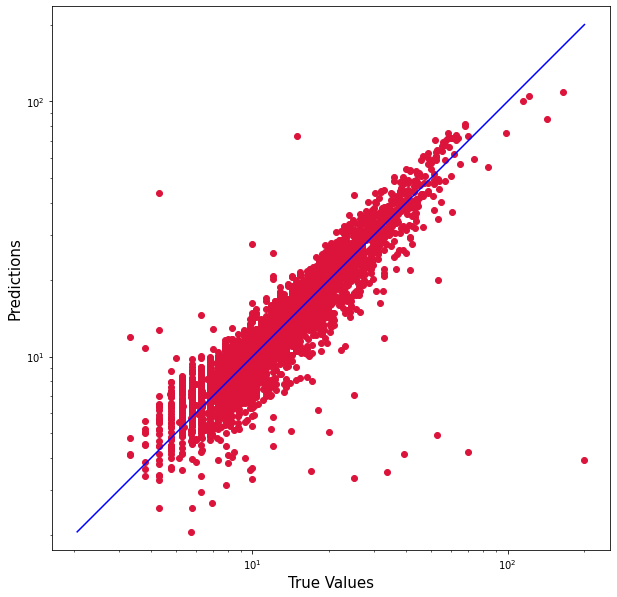

In [0]:
display(image)

Trying the model with a different set of hyperparameters is as easy as changing the inputs to our method.

In [0]:
# L1 penalty, regularization parameter 0.3, 50 iterations
train_nyc_taxi(trainingData, testData, label_column, "features", 1.0, 0.3, 50)

Linear regression model (elasticNetParam=1.000000, regParam=0.300000, maxIter=50.000000):
  RMSE: 5.224525975596698
  MAE: 2.198313990976637
  R2: 0.7836611624718266


2023/03/21 10:44:15 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


In this case, the R^2 went up and RMSE went down, both of which are good signs.  This model is marginally better than the first:  we are approximately 15 cents more accurate and explain approximately 1% more of the total variance.  These are not enormous changes, but are a step in the right direction.

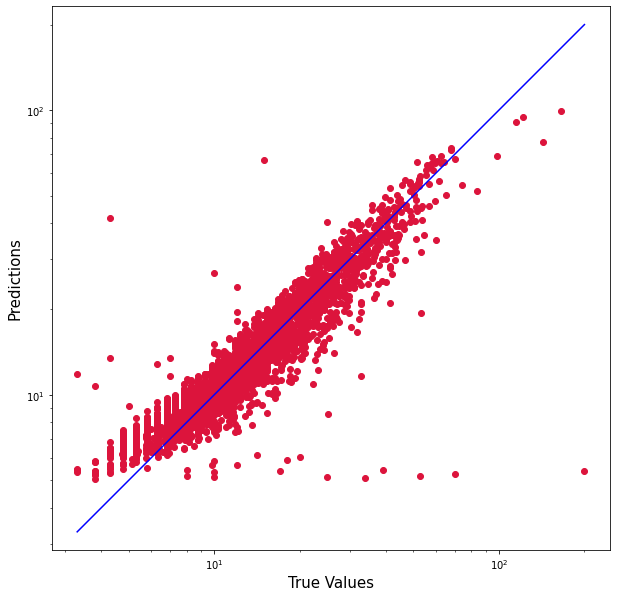

In [0]:
display(image)

That said, it does appear that the results for inexpensive rides skew high, meaning that the predictions were larger than actual values.  We can see this in the shape of the curve:  near the bottom-left corner, we see that the red dots (which signify individual data points) are almost all above the blue line.  Contrast this to the first image, where the data points were on both sides of the line.

In [0]:
# 50/50 mixed L1 and L2, regularization parameter 0.9, 1000 iterations
train_nyc_taxi(trainingData, testData, label_column, "features", 0.5, 0.9, 1000)

Linear regression model (elasticNetParam=0.500000, regParam=0.900000, maxIter=1000.000000):
  RMSE: 5.28285295546705
  MAE: 2.2689399865200164
  R2: 0.7788037543974033


2023/03/21 10:46:24 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


This third execution is somewhere between the first and the second.  As we can see in the image below, this suffers from the same skew as our second model.

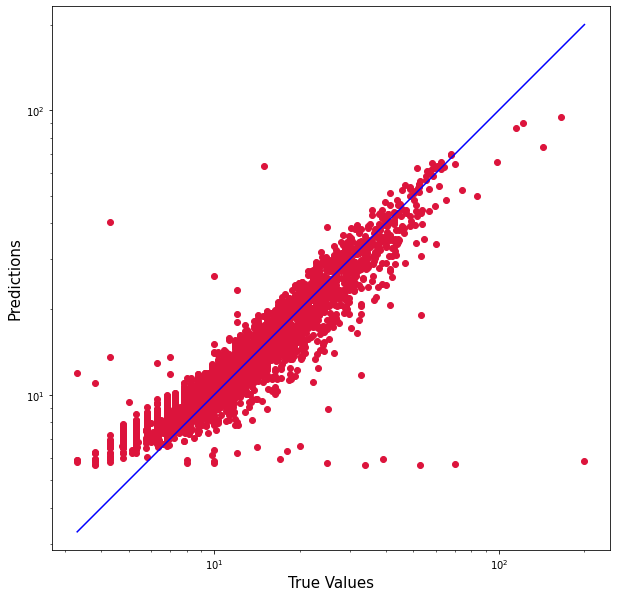

In [0]:
display(image)

This information is now stored in the MLflow tracking server.  In the next exercise, we will learn two methods of working with this data:  by reviewing the experiment details in the Databricks user interface, as well as interacting with MLflow programmatically.

## Reviewing Experiment Metrics

There are two techniques you can use to review the results of different runs in your experiment.  The first method is to use the Databricks user interface to view experiment and run details.  The second method is to access these details programmatically.

### View the Experiment, Runs, and Run Details with the Databricks UI

The first way that you can access information on experiments, runs, and run details is via the Databricks UI.

1. Select the **Experiment** option in the notebook context bar (at the top of this page and on the right-hand side) to display the Experiment sidebar. In the sidebar, you can view the run parameters and metrics.  Review the run parameters by selecting the first **[+]**.  This will display each parameter that you logged on a separate line.  Then, select the second **[+]**.  This will expand out and display each metric that you logged.  Below these two, there is a link to each model you saved in a run, as well as the type (in this case, `spark`).
   
1. Select the External Link icon in the Experiment Runs context bar to view additional details on a particular run.  These details open out in a new tab and include the parameters and metrics, as well as any tags you created for a run.  You can set tags using `mlflow.set_tags()`, or use the UI afterward to add tags after the fact.  In addition, you can review artifacts.  In the prior exercise, you created a model as well as an image for each run.  This interface will allow you to see the generated image even after you clear this notebook.

Review each of the runs in the user interface.

#### Reproducing a Run

After you have reviewed the runs, try to reproduce the results of this experiment.  Reproducability is critical in machine learning, as it allows people to build confidence in the quality of generated models, as well as help ensure that the model out in production really is the same as what you expect.  To do this in Azure Databricks is as simple as selecting the **Reproduce Run** option for an experiment run.  This will open a modal dialog with three steps:  cloning the notebook, recreating a cluster, and installing relevant cluster libraries.  Select **Confirm** to create a new notebook.  Attach this new notebook to a cluster and run through the steps.

### View the Experiment, Runs, and Run Details Programmatically

You can also obtain experiment details using the Spark language of your choice.  To access this data, you will create an `MlflowClient`.

In [0]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

print('Loaded MLflow Client')

Loaded MLflow Client


Next, generate a list of experiments.

In [0]:
client.search_experiments()

Out[13]: [<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1988255026187153', creation_time=1679394959184, experiment_id='1988255026187153', last_update_time=1679395574350, lifecycle_stage='active', name=('/Users/reddytechconnect@gmail.com/03 - Managing Experiments and Models/01 - '
  'Using MLflow to Track Experiments'), tags={'mlflow.experiment.sourceName': '/Users/reddytechconnect@gmail.com/03 - '
                                  'Managing Experiments and Models/01 - Using '
                                  'MLflow to Track Experiments',
  'mlflow.experimentType': 'NOTEBOOK',
  'mlflow.ownerEmail': 'reddytechconnect@gmail.com',
  'mlflow.ownerId': '3790246273816926'}>,
 <Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1988255026187150', creation_time=1679390686082, experiment_id='1988255026187150', last_update_time=1679390862925, lifecycle_stage='active', name=('/Users/reddytechconnect@gmail.com/02 - Training and Evaluating Machine '
  'Learning Mod

The list above provides information on each experiment, including the origin of the experiment.  Select the experiment you recently created by replacing `expriment_num` below with the appropriate number.  Remember that Python lists are zero-based, so if your experiment is the first in the list, you will want to set `experiment_num` to 0!

In [0]:
# Replace experiment_num with the appropriate experiment number based on the list of experiments above.
experiment_num = 0 # FILL IN!

experiment_id = client.search_experiments()[experiment_num].experiment_id
runs_df = mlflow.search_runs(experiment_id)

display(runs_df)

run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mae,metrics.rmse,metrics.r2,params.max_iter,params.elastic_net_param,params.reg_param,params.StringIndexer_3.handleInvalid,params.Imputer.inputCols,params.StringIndexer_2.outputCol,params.StringIndexer_4.inputCol,params.stages,params.VectorAssembler_2.inputCols,params.Imputer.strategy,params.OneHotEncoder_1.outputCol,params.Imputer.missingValue,params.StringIndexer_1.inputCol,params.StringIndexer_1.outputCol,params.OneHotEncoder_1.dropLast,params.StringIndexer_1.stringOrderType,params.MinMaxScaler.inputCol,params.OneHotEncoder_4.outputCol,params.OneHotEncoder_3.dropLast,params.OneHotEncoder_1.inputCols,params.StringIndexer_4.stringOrderType,params.OneHotEncoder_4.handleInvalid,params.StringIndexer_2.stringOrderType,params.OneHotEncoder_3.inputCols,params.VectorAssembler_1.inputCols,params.StringIndexer_3.inputCol,params.OneHotEncoder_3.handleInvalid,params.VectorAssembler_1.handleInvalid,params.Imputer.relativeError,params.OneHotEncoder_4.outputCols,params.OneHotEncoder_1.outputCols,params.OneHotEncoder_2.outputCol,params.VectorAssembler_2.outputCol,params.Imputer.outputCol,params.StringIndexer_4.outputCol,params.OneHotEncoder_4.inputCols,params.OneHotEncoder_2.handleInvalid,params.StringIndexer_3.stringOrderType,params.OneHotEncoder_4.dropLast,params.StringIndexer_2.inputCol,params.VectorAssembler_2.handleInvalid,params.MinMaxScaler.min,params.StringIndexer_4.handleInvalid,params.VectorAssembler_1.outputCol,params.OneHotEncoder_2.inputCols,params.MinMaxScaler.outputCol,params.OneHotEncoder_2.dropLast,params.OneHotEncoder_3.outputCols,params.OneHotEncoder_1.handleInvalid,params.MinMaxScaler.max,params.OneHotEncoder_2.outputCols,params.OneHotEncoder_3.outputCol,params.StringIndexer_1.handleInvalid,params.StringIndexer_2.handleInvalid,params.Imputer.outputCols,params.StringIndexer_3.outputCol,tags.mlflow.databricks.notebookRevisionID,tags.mlflow.databricks.workspaceID,tags.mlflow.source.name,tags.mlflow.databricks.notebookPath,tags.mlflow.databricks.notebookID,tags.sparkDatasourceInfo,tags.mlflow.log-model.history,tags.mlflow.databricks.notebook.commandID,tags.mlflow.source.type,tags.mlflow.databricks.webappURL,tags.mlflow.databricks.cluster.libraries,tags.mlflow.user,tags.mlflow.databricks.workspaceURL,tags.mlflow.runName,tags.mlflow.databricks.cluster.info,tags.mlflow.databricks.cluster.id,tags.estimator_class,tags.mlflow.autologging,tags.estimator_name
fb7c5b4b44e6494daa0b2da32882fc6f,1988255026187153,FINISHED,dbfs:/databricks/mlflow-tracking/1988255026187153/fb7c5b4b44e6494daa0b2da32882fc6f/artifacts,2023-03-21T10:46:14.350+0000,2023-03-21T10:47:55.481+0000,2.2689399865200164,5.28285295546705,0.7788037543974033,1000,0.5,0.9,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1679395675683,8342446003725372,/Users/reddytechconnect@gmail.com/03 - Managing Experiments and Models/01 - Using MLflow to Track Experiments,/Users/reddytechconnect@gmail.com/03 - Managing Experiments and Models/01 - Using MLflow to Track Experiments,1988255026187153,"path=dbfs:/user/hive/warehouse/nyc_taxi,version=1,format=delta","[{""artifact_path"":""model"",""flavors"":{""spark"":{""pyspark_version"":""3.3.2.dev0"",""model_data"":""sparkml"",""code"":null},""python_function"":{""loader_module"":""mlflow.spark"",""python_version"":""3.9.5"",""data"":""sparkml"",""env"":{""conda"":""conda.yaml"",""virtualenv"":""python_env.yaml""}}},""run_id"":""fb7c5b4b44e6494daa0b2da32882fc6f"",""model_uuid"":""e5296311a75844f88e72f350a1856149"",""utc_time_created"":""2023-03-21 10:46:24.139890"",""mlflow_version"":""2.1.1"",""databricks_runtime"":""12.2.x-cpu-ml-scala2.12""}]",7252658849934833564_9157151427604158333_cb7ab2206ee34d7c989665c809e6943e,NOTEBOOK,https://eastus-c3.azuredatabrick

The table above includes a variety of information about each run, including details on your logged metrics, the parameters you used, and a variety of system- and user-generated tags.  This makes it easy to export information on an experiment for further analysis.

Next, you will retrieve the last run in this experiment as ordered by start time.  It is possible to retrieve information about an individual run.  For example, `data.metrics` will return a JSON set of key-value pairs, one for each saved metric.

In [0]:
runs = client.search_runs(experiment_id, order_by=["attributes.start_time desc"], max_results=1)
last_run = runs[0]
last_run.data.metrics

Out[15]: {'mae': 2.2689399865200164, 'r2': 0.7788037543974033, 'rmse': 5.28285295546705}

It is also possible to retrieve model details for a particular run, including loading the model itself.  In this case, you will use the `load_model()` method in `mlflow.spark` to retrieve a Spark model.  The `info.run_uuid` attribute allows us to select the model generated by this particular run.  After we have selected the model, we can use it to generate predictions.

In [0]:
%python
loaded_model = mlflow.spark.load_model(f"runs:/{last_run.info.run_uuid}/model")
top_rows = sqlContext.createDataFrame(testData.head(3))
display(loaded_model.transform(top_rows))

2023/03/21 10:51:48 INFO mlflow.spark: 'runs:/fb7c5b4b44e6494daa0b2da32882fc6f/model' resolved as 'dbfs:/databricks/mlflow-tracking/1988255026187153/fb7c5b4b44e6494daa0b2da32882fc6f/artifacts/model'


passengerCount,tripDistance,day_of_week,month_num,normalizeHolidayName,isPaidTimeOff,snowDepth,precipTime,precipDepth,temperature,totalAmount,hour_sine,hour_cosine,numerical_features,scaled_numerical_features,day_of_week_index,day_of_week_classVector,month_num_index,month_num_classVector,normalizeHolidayName_index,normalizeHolidayName_classVector,isPaidTimeOff_index,isPaidTimeOff_classVector,features,prediction
1.0,0.01,3,1,None,0,0.0,6.0,0.0,3.180645161290322,52.8,0.7071067811865476,-0.7071067811865475,"Map(vectorType -> dense, length -> 8, values -> List(1.0, 0.01, 0.0, 6.0, 0.0, 3.180645161290322, 0.7071067811865476, -0.7071067811865475))","Map(vectorType -> sparse, length -> 8, indices -> List(3, 5, 6, 7), values -> List(0.21739130434782608, 0.4150031902945756, 0.8535533905932737, 0.14644660940672627))",3.0,"Map(vectorType -> sparse, length -> 6, indices -> List(3), values -> List(1.0))",3.0,"Map(vectorType -> sparse, length -> 5, indices -> List(3), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 24, indices -> List(3, 9, 11, 15, 19, 21, 22, 23), values -> List(1.0, 1.0, 1.0, 1.0, 0.21739130434782608, 0.4150031902945756, 0.8535533905932737, 0.14644660940672627))",5.652157175962218
1.0,0.01,5,6,None,0,0.0,1.0,0.0,22.944736842105275,3.8,0.25881904510252074,0.9659258262890683,"Map(vectorType -> dense, length -> 8, values -> List(1.0, 0.01, 0.0, 1.0, 0.0, 22.944736842105275, 0.25881904510252074, 0.9659258262890683))","Map(vectorType -> sparse, length -> 8, indices -> List(5, 6, 7), values -> List(0.9102995002049119, 0.6294095225512604, 0.9829629131445341))",1.0,"Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0))",2.0,"Map(vectorType -> sparse, length -> 5, indices -> List(2), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 24, indices -> List(1, 8, 11, 15, 21, 22, 23), values -> List(1.0, 1.0, 1.0, 1.0, 0.9102995002049119, 0.6294095225512604, 0.9829629131445341))",5.652157175962218
1.0,0.02,4,3,None,0,0.0,24.0,15.0,15.874242424242427,33.8,-0.7071067811865477,0.7071067811865474,"Map(vectorType -> dense, length -> 8, values -> List(1.0, 0.02, 0.0, 24.0, 15.0, 15.874242424242427, -0.7071067811865477, 0.7071067811865474))","Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.598976654940838E-4, 0.0, 1.0, 0.0015001500150015003, 0.7331099864662923, 0.14644660940672616, 0.8535533905932737))",0.0,"Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 5, indices -> List(1), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 24, indices -> List(0, 7, 11, 15, 17, 19, 20, 21, 22, 23), values -> List(1.0, 1.0, 1.0, 1.0, 1.598976654940838E-4, 1.0, 0.0015001500150015003, 0.7331099864662923, 0.14644660940672616, 0.8535533905932737))",5.683835994490361
